# The purpose of this script is to test out numba compilation on the forward Euler/finite difference method runs

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

import FiniteDifferenceCompiled as fd
import LiquidCrystalHelperCompiled as lch

from scipy.signal import find_peaks
from scipy.signal import find_peaks_cwt

import time
import timeit
from importlib import reload

import ipywidgets as widgets
from IPython.display import display
from IPython.display import Video
from IPython.display import Image

In [2]:
reload(fd)
reload(lch)

<module 'LiquidCrystalHelperCompiled' from 'C:\\Users\\lucas\\Documents\\Grad Work\\Summer Research 2020\\LiquidCrystalHelperCompiled.py'>

In [3]:
%matplotlib inline
dpi = 700
mpl.rcParams['figure.dpi'] = dpi

In [18]:
l = 10
n = 600

x = np.linspace(-l, l, num=n)
y = np.linspace(-l, l, num=n)
X, Y = np.meshgrid(x, y, indexing='ij')

S_val = 0.5
ctr = [[-2, 0], [2, 0]]
r = [1, 1]
m = [-1/2, 1/2]

S, phi = lch.makeMultiDisclination(X, Y, S_val, ctr, r, m)
Q = lch.uniaxialQ(S, phi)
eta, mu, nu = lch.auxVars(Q)

In [24]:
dx = X[1, 0] - X[0, 0]
dy = Y[0, 1] - Y[0, 0]

# This is just what they said it should be for stability
dt = dx**2/8

num_steps = 20000
peak_pos = np.zeros((2, num_steps))
t = np.zeros(num_steps)
widths = np.arange(0, 1.5, 0.05)

middle = np.floor(n/2).astype('int')
middle_slice = np.zeros((n, num_steps))

eta_old = eta
mu_old = mu
nu_old = nu

# Create loading bar
progress = widgets.IntProgress(min=0, max=num_steps)
display(progress)

etaEuler = fd.makeForwardEuler(lch.etaEOM)
muEuler = fd.makeForwardEuler(lch.muEOM)
nuEuler = fd.makeForwardEuler(lch.nuEOM)

start_time = time.perf_counter()
for i in range(num_steps):
    
    eta_new = etaEuler(eta_old, dt, mu_old, nu_old, dx, dy)
    mu_new = muEuler(mu_old, dt, eta_old, nu_old, dx, dy)
    nu_new = nuEuler(nu_old, dt, eta_old, mu_old, dx, dy)
    
    eta_old = eta_new
    mu_old = mu_new
    nu_old = nu_new
    
    lambda_max = lch.calcQEigenvals(eta_old, mu_old, nu_old)
    peaks, _ = find_peaks(-lambda_max[:, middle])
    peak_pos[:, i] = X[peaks, middle]
    
    middle_slice[:, i] = lambda_max[:, middle]
    
    t[i] = i*dt
    
    # Update loading bar
    progress.value = i
    
end_time = time.perf_counter()

IntProgress(value=0, max=20000)

In [25]:
print((end_time - start_time)/60)

6.766365901666668


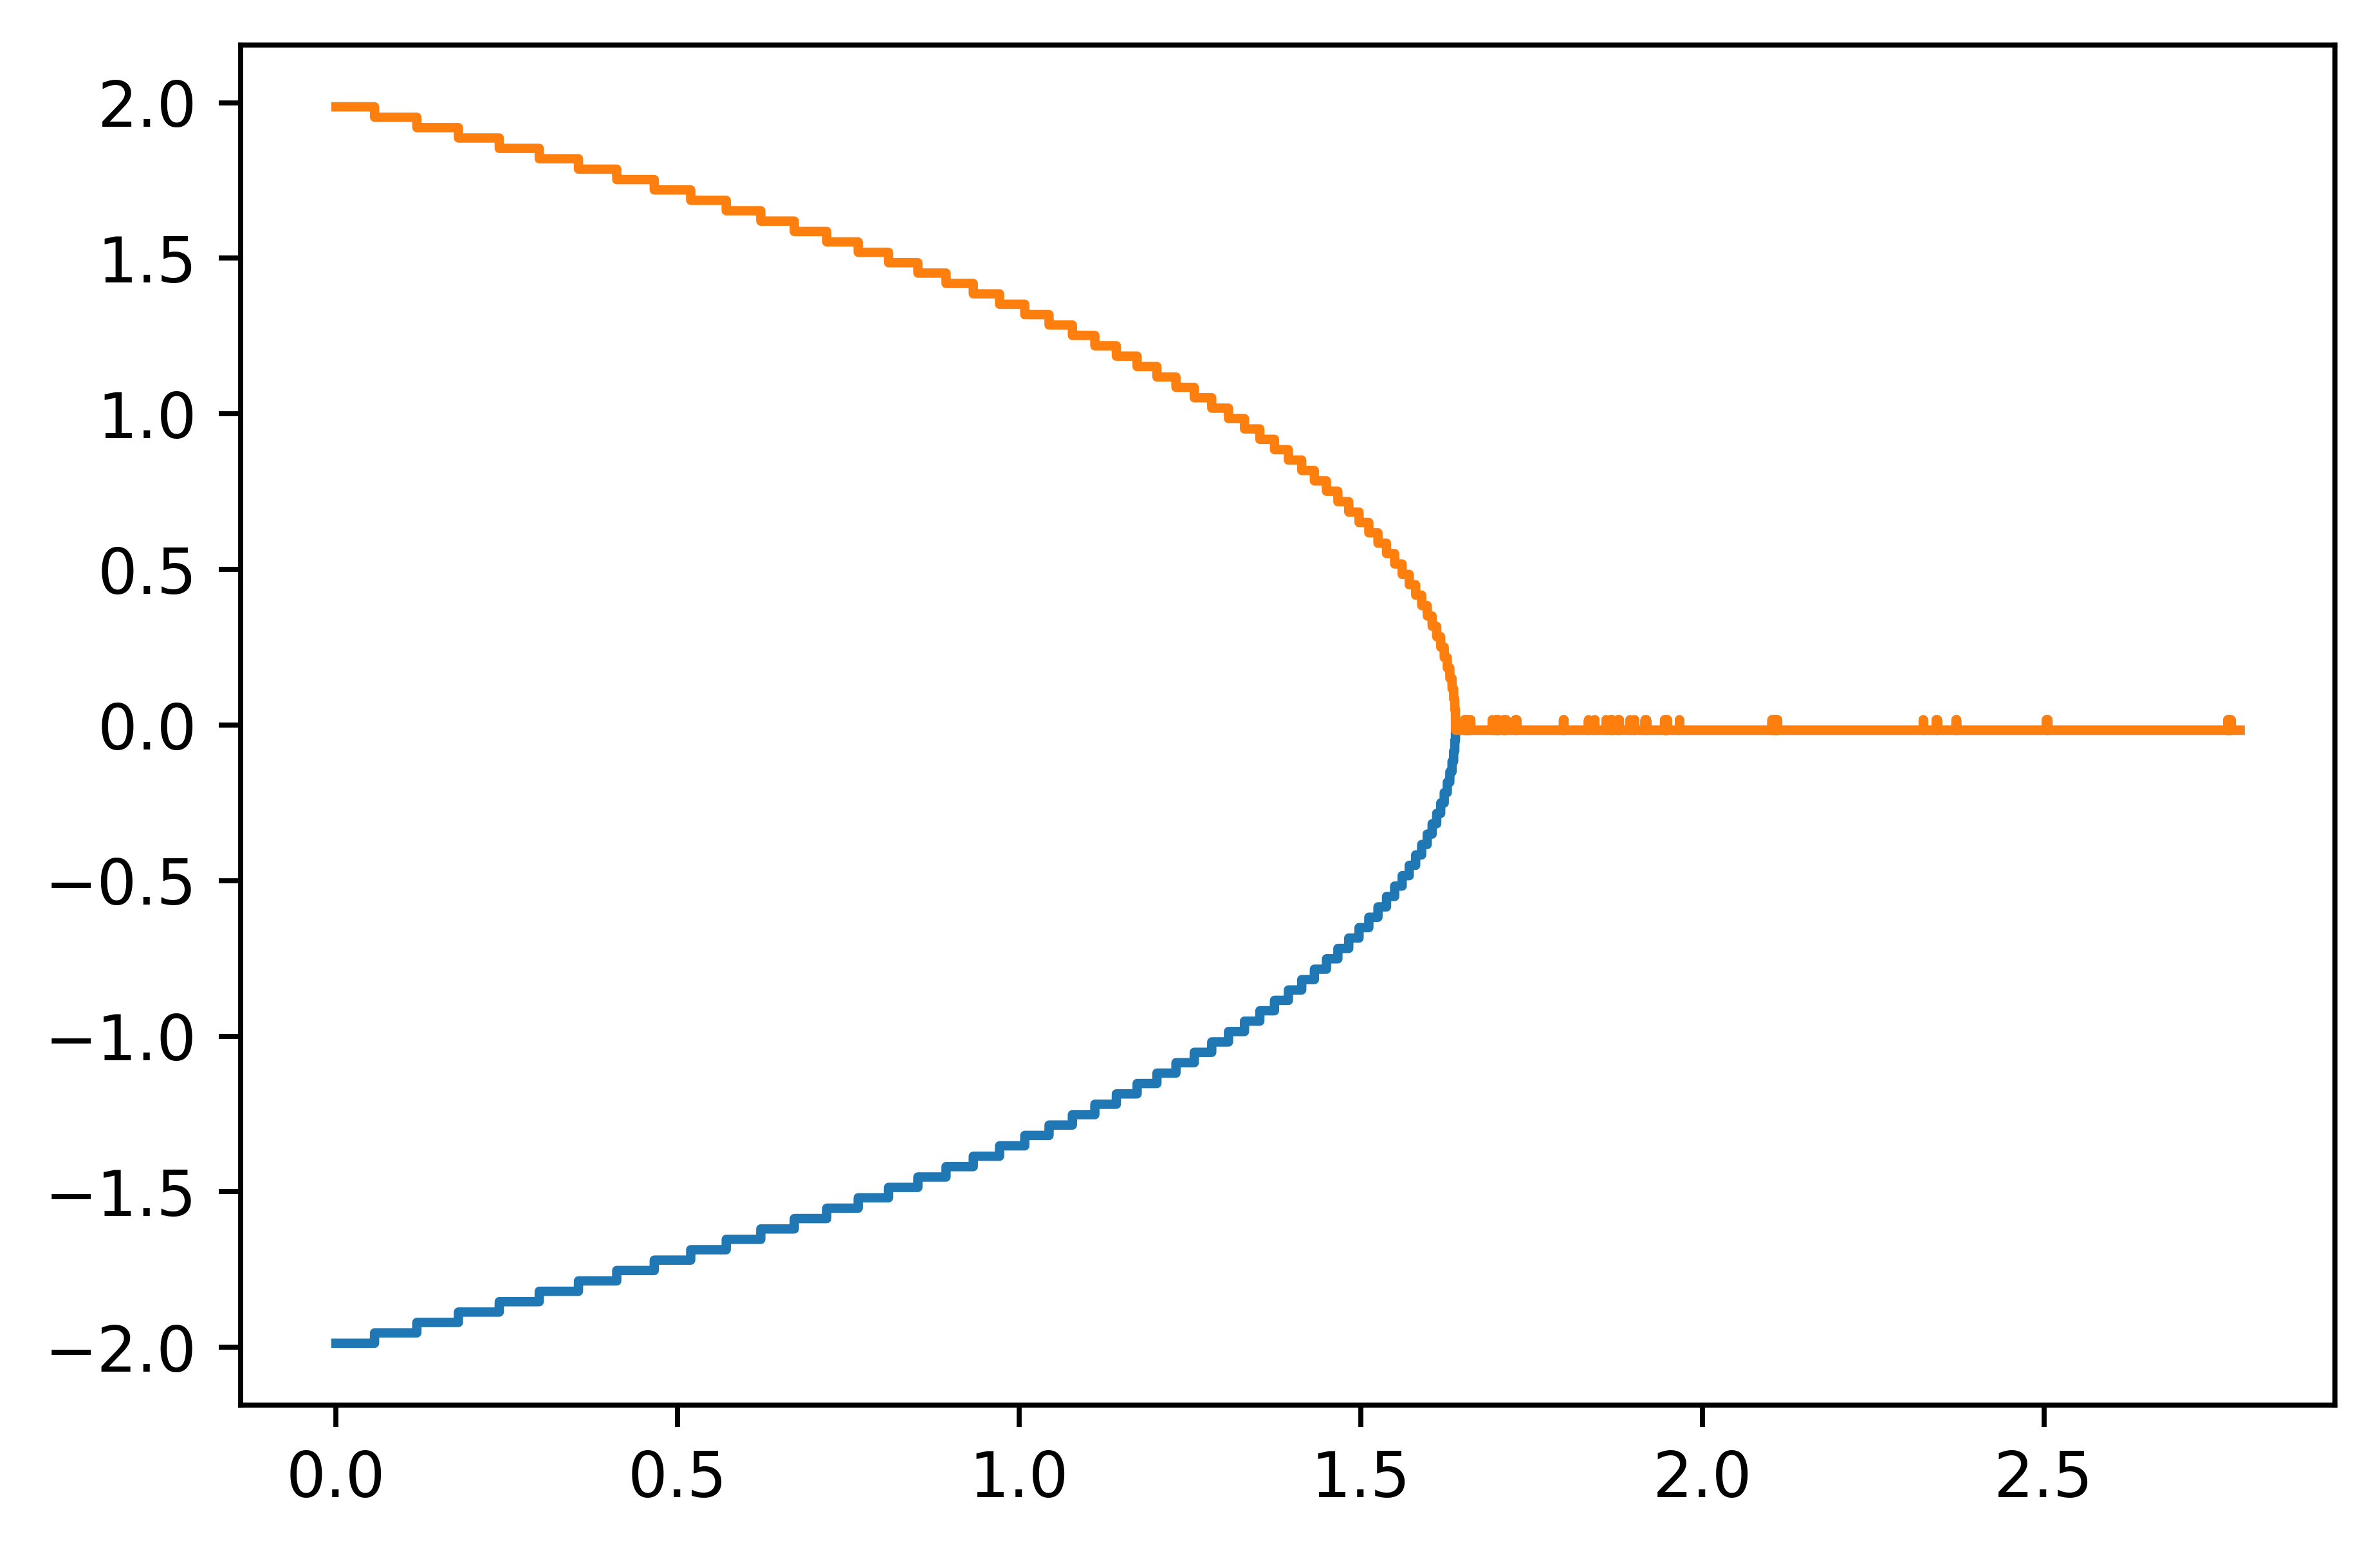

In [26]:
plt.plot(t[:], peak_pos[0, :])
plt.plot(t[:], peak_pos[1, :])

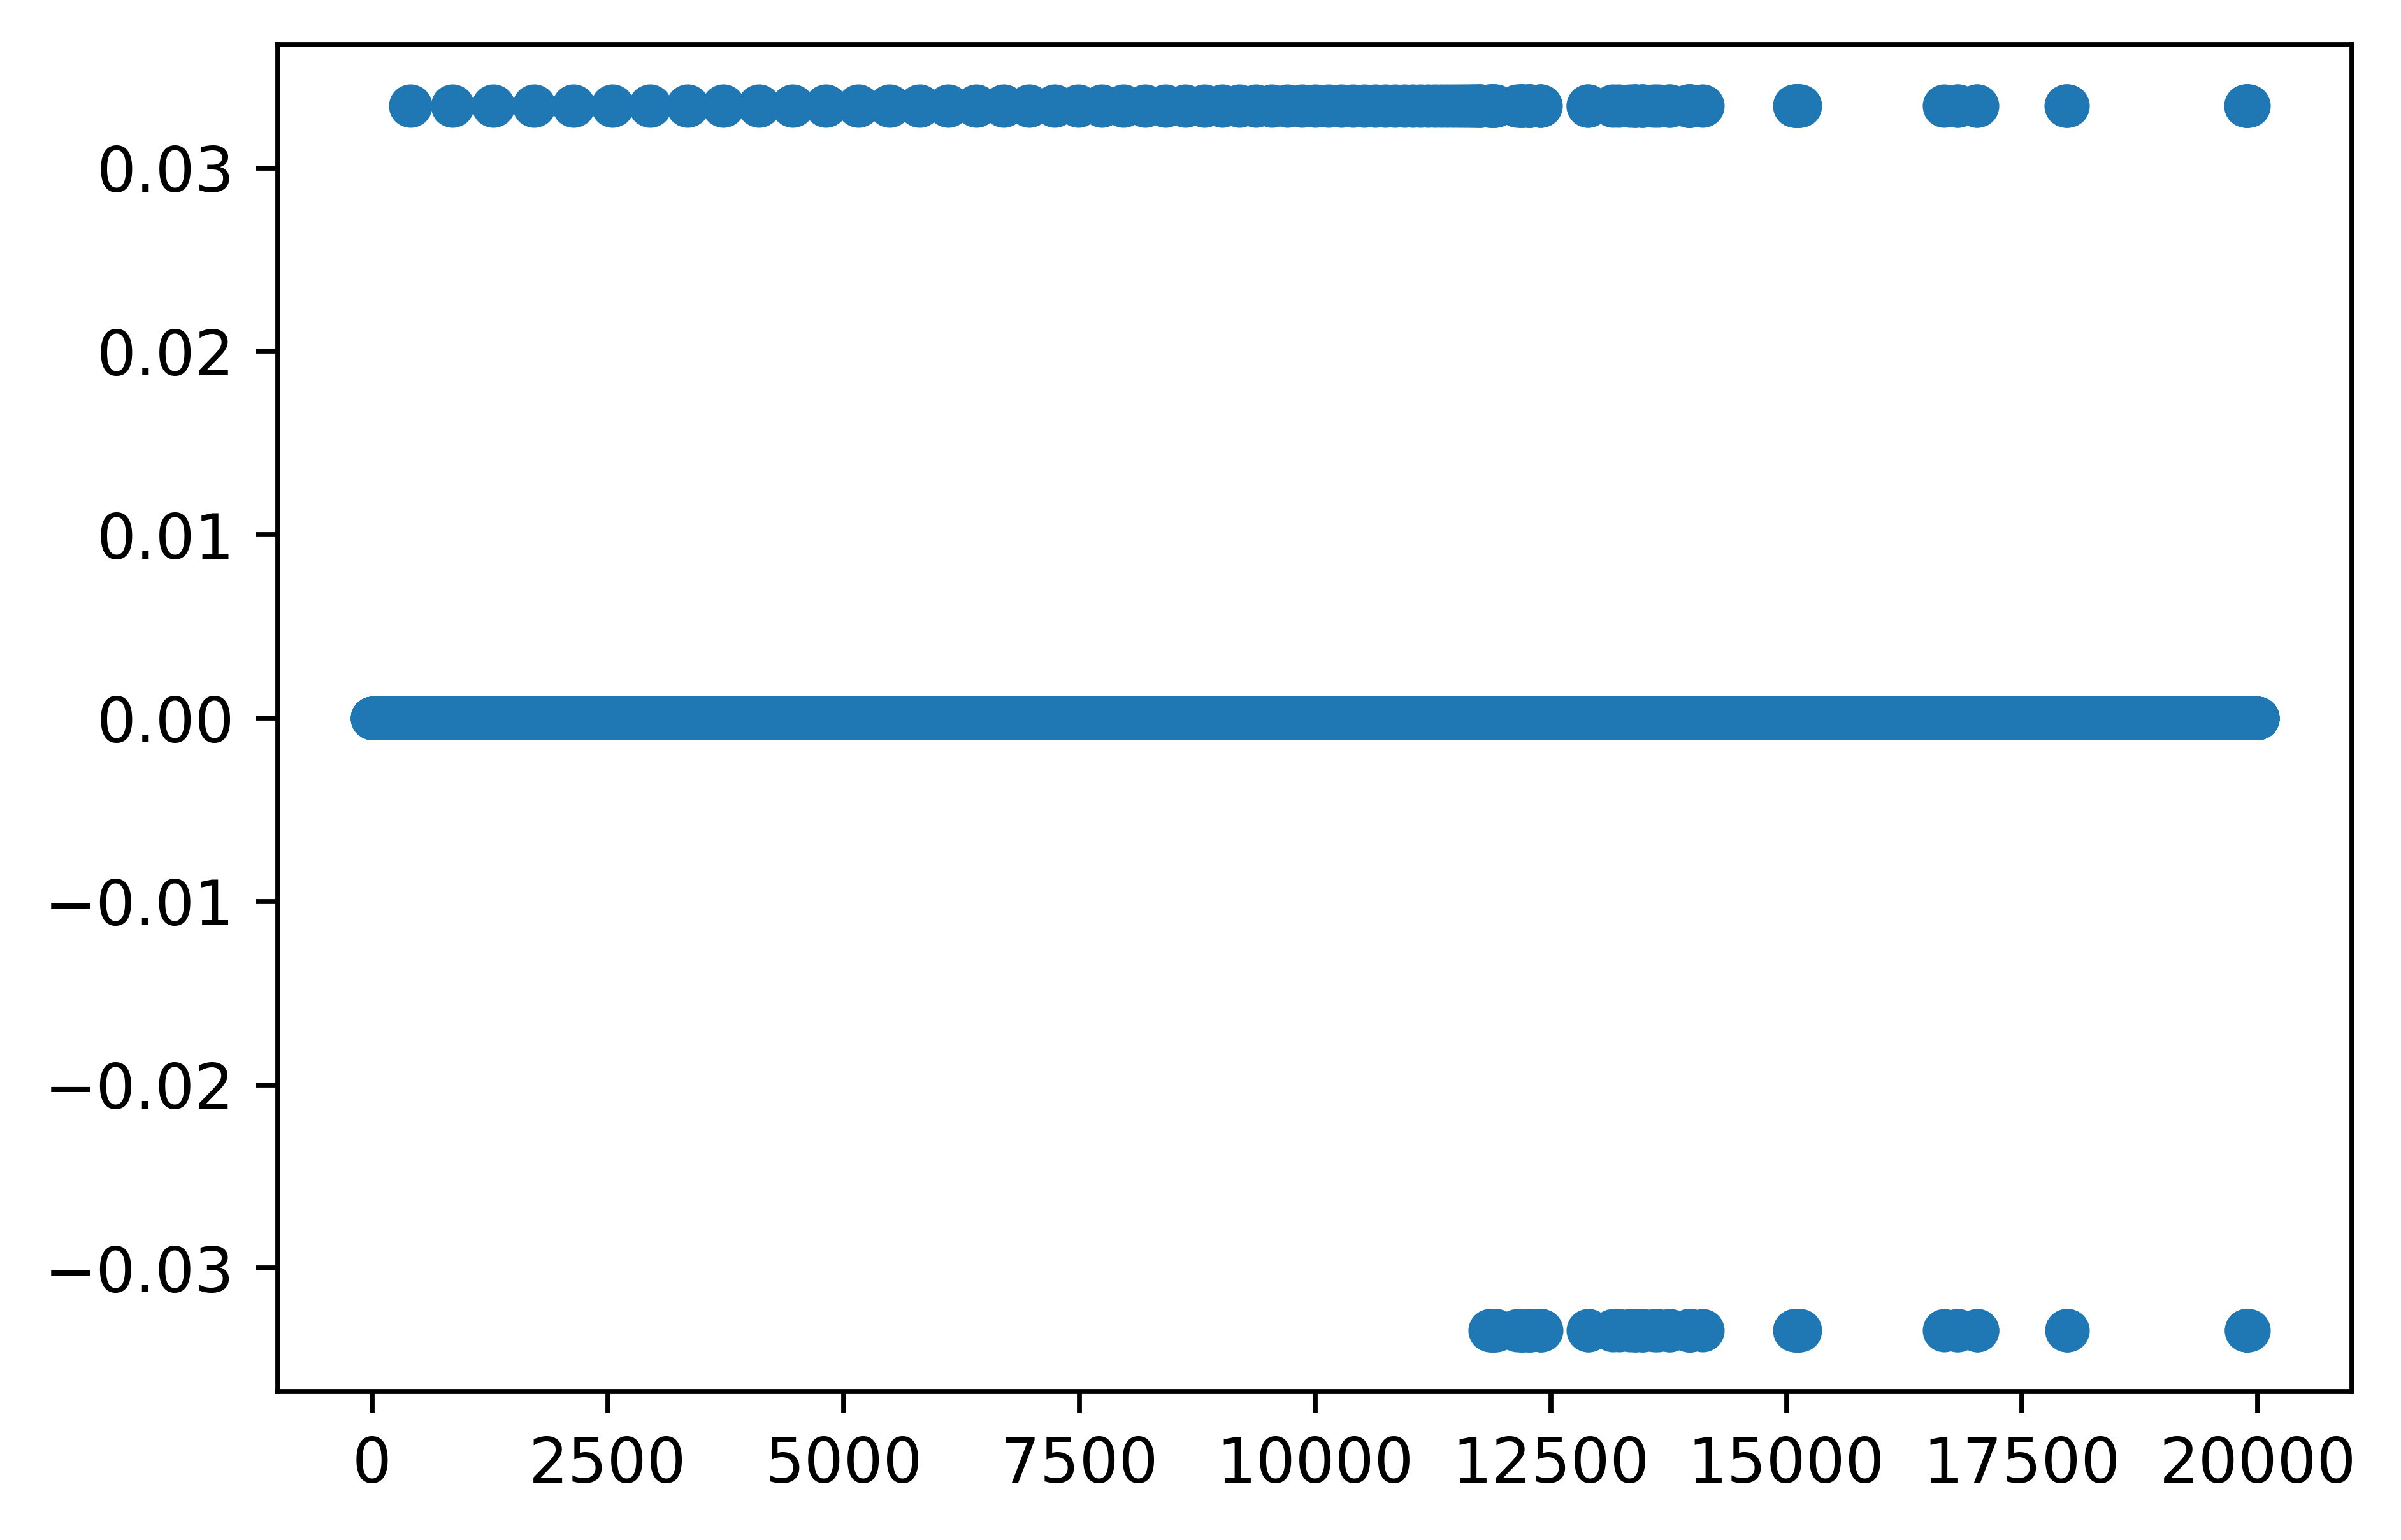

In [27]:
plt.plot(np.diff(peak_pos[0, :]), marker='o', ls='')

In [29]:
2*l/n

0.03333333333333333